In [49]:
from sklearn.decomposition import PCA
import numpy as np
import optuna
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                        roc_curve, auc, roc_auc_score, log_loss)
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder, label_binarize
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from typing import Dict, List, Any, Tuple
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.model_selection import train_test_split

In [50]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# data_path = '/home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/pipeline/modified/feature_extracted_data/two_class_pp_5s_0.5.csv'
data_path = '/home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/pipeline/feature_extracted_data/three_class_pp_5s_0.5.csv'
features = pd.read_csv(data_path)
features.drop(columns=['center_time', 'start_time', 'end_time'], inplace=True)

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(features['label'])

features['label'] = labels

X = features.drop(columns=['experiment_id'])
y = features['label']
groups = features['experiment_id']



In [51]:
columns = X.columns
columns_list = list(columns)


In [52]:
target = 'label'

<Axes: >

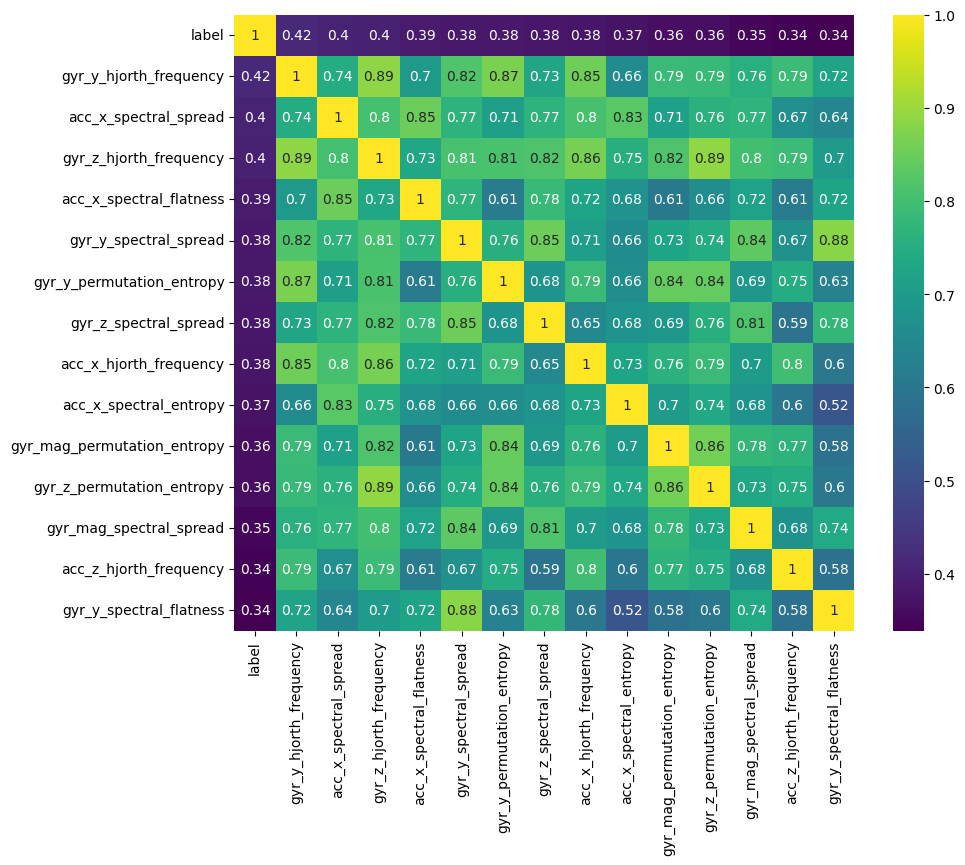

In [53]:

k = 15 # Number of features in the heatmap
cols = X[columns].corr().nlargest(k, target)[target].index
cm = X[cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='viridis')

In [54]:
def generate_accuracy_and_heatmap(model, X, y):
    y_pred = model.predict(X)
    
    # Define class order with 'void' first (even though it's encoded as 1)
    # classes_ordered = ['void', 'non-void']  # Display order you want
    # labels_ordered = [1, 0]  # Corresponding encoded values
    
    classes_ordered = ['pre-void','void', 'post-void']  # Display order you want
    labels_ordered = [1, 2, 0]  # Corresponding encoded values
    
    ac = accuracy_score(y, y_pred)
    # f_score = f1_score(y, y_pred, average='macro', pos_label=1)  # void as positive
    f_score = f1_score(y, y_pred, average='macro', pos_label=2)  # void as positive
    
    print("Accuracy is: ", ac)
    print("F1 Score is: ", f_score)
    print('\n')
    
    # Crosstab
    print(pd.crosstab(pd.Series(y_pred, name='Predicted'), 
                    pd.Series(y, name='Actual')))
    print('\n')
    
    # Confusion matrix with void on top
    cm = confusion_matrix(y, y_pred, labels=labels_ordered)  # [1, 0] order
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                    display_labels=classes_ordered)  # ['void', 'non-void']
    cm_display.plot()
    plt.show()
    
    # Classification report with void first
    report = classification_report(y, y_pred, 
                                labels=labels_ordered,  # [1, 0]
                                target_names=classes_ordered)  # ['void', 'non-void']
    print("Classification Report:")
    print(report)
    
    return 1

In [55]:
X = features.drop(columns=['label', 'experiment_id'])
y = features['label']
groups = features['experiment_id']

In [56]:
splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx] 

In [57]:
from xgboost import XGBClassifier
model = XGBClassifier()

model.fit(X_train, y_train)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


Accuracy is:  0.5185185185185185
F1 Score is:  0.510543882513748


Actual      0  1   2
Predicted           
0          10  1   5
1           2  1  14
2           0  4   6




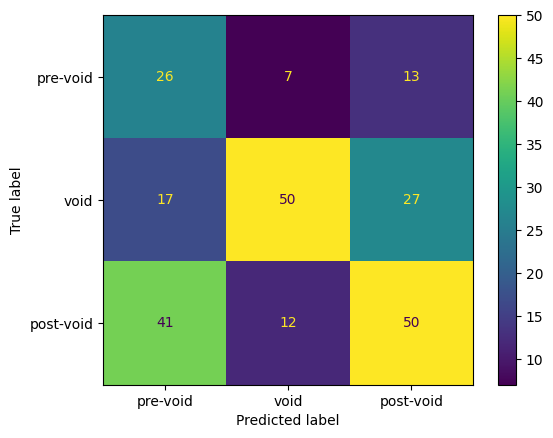

Classification Report:
              precision    recall  f1-score   support

    pre-void       0.31      0.57      0.40        46
        void       0.72      0.53      0.61        94
   post-void       0.56      0.49      0.52       103

    accuracy                           0.52       243
   macro avg       0.53      0.53      0.51       243
weighted avg       0.57      0.52      0.53       243



1

In [58]:
generate_accuracy_and_heatmap(model, X_test, y_test)

In [59]:
# select_feature = SelectKBest(chi2, k=5).fit(X_train, y_train)
select_feature = SelectKBest(f_classif, k=5).fit(X_train, y_train)

In [60]:
# Ensure full display
pd.set_option("display.max_rows", None)   # Show all rows
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.width", None)    # No wrapping
pd.set_option("display.max_colwidth", None)  # Show long column values

selected_features_df = pd.DataFrame({'Feature':list(X_train.columns),
                                    'Scores':select_feature.scores_})
selected_features_df.sort_values(by='Scores', ascending=False)

,Feature,Scores
104,gyr_y_hjorth_frequency,75.673145
101,gyr_y_spectral_spread,71.743960
12,acc_x_spectral_flatness,70.653630
122,gyr_z_hjorth_frequency,70.087865
119,gyr_z_spectral_spread,65.791367
14,acc_x_hjorth_frequency,61.906949
90,gyr_y_permutation_entropy,61.655204
11,acc_x_spectral_spread,58.967366
102,gyr_y_spectral_flatness,57.784648
100,gyr_y_spectral_centroid,53.495998


In [61]:
X_train_selected = select_feature.transform(X_train)
X_test_selected = select_feature.transform(X_test)

In [62]:
X_train.head()

,acc_x_permutation_entropy,acc_x_spectral_entropy,acc_x_mean,acc_x_std,acc_x_range,acc_x_rms,acc_x_var,acc_x_min,acc_x_max,acc_x_time_energy,acc_x_spectral_centroid,acc_x_spectral_spread,acc_x_spectral_flatness,acc_x_peak_frequency_ratio,acc_x_hjorth_frequency,acc_x_spectral_skewness,acc_x_spectral_kurtosis,acc_x_snr,acc_y_permutation_entropy,acc_y_spectral_entropy,acc_y_mean,acc_y_std,acc_y_range,acc_y_rms,acc_y_var,acc_y_min,acc_y_max,acc_y_time_energy,acc_y_spectral_centroid,acc_y_spectral_spread,acc_y_spectral_flatness,acc_y_peak_frequency_ratio,acc_y_hjorth_frequency,acc_y_spectral_skewness,acc_y_spectral_kurtosis,acc_y_snr,acc_z_permutation_entropy,acc_z_spectral_entropy,acc_z_mean,acc_z_std,acc_z_range,acc_z_rms,acc_z_var,acc_z_min,acc_z_max,acc_z_time_energy,acc_z_spectral_centroid,acc_z_spectral_spread,acc_z_spectral_flatness,acc_z_peak_frequency_ratio,acc_z_hjorth_frequency,acc_z_spectral_skewness,acc_z_spectral_kurtosis,acc_z_snr,acc_mag_permutation_entropy,acc_mag_spectral_entropy,acc_mag_mean,acc_mag_std,acc_mag_range,acc_mag_rms,acc_mag_var,acc_mag_min,acc_mag_max,acc_mag_time_energy,acc_mag_spectral_centroid,acc_mag_spectral_spread,acc_mag_spectral_flatness,acc_mag_peak_frequency_ratio,acc_mag_hjorth_frequency,acc_mag_spectral_skewness,acc_mag_spectral_kurtosis,acc_mag_snr,gyr_x_permutation_entropy,gyr_x_spectral_entropy,gyr_x_mean,gyr_x_std,gyr_x_range,gyr_x_rms,gyr_x_var,gyr_x_min,gyr_x_max,gyr_x_time_energy,gyr_x_spectral_centroid,gyr_x_spectral_spread,gyr_x_spectral_flatness,gyr_x_peak_frequency_ratio,gyr_x_hjorth_frequency,gyr_x_spectral_skewness,gyr_x_spectral_kurtosis,gyr_x_snr,gyr_y_permutation_entropy,gyr_y_spectral_entropy,gyr_y_mean,gyr_y_std,gyr_y_range,gyr_y_rms,gyr_y_var,gyr_y_min,gyr_y_max,gyr_y_time_energy,gyr_y_spectral_centroid,gyr_y_spectral_spread,gyr_y_spectral_flatness,gyr_y_peak_frequency_ratio,gyr_y_hjorth_frequency,gyr_y_spectral_skewness,gyr_y_spectral_kurtosis,gyr_y_snr,gyr_z_permutation_entropy,gyr_z_spectral_entropy,gyr_z_mean,gyr_z_std,gyr_z_range,gyr_z_rms,gyr_z_var,gyr_z_min,gyr_z_max,gyr_z_time_energy,gyr_z_spectral_centroid,gyr_z_spectral_spread,gyr_z_spectral_flatness,gyr_z_peak_frequency_ratio,gyr_z_hjorth_frequency,gyr_z_spectral_skewness,gyr_z_spectral_kurtosis,gyr_z_snr,gyr_mag_permutation_entropy,gyr_mag_spectral_entropy,gyr_mag_mean,gyr_mag_std,gyr_mag_range,gyr_mag_rms,gyr_mag_var,gyr_mag_min,gyr_mag_max,gyr_mag_time_energy,gyr_mag_spectral_centroid,gyr_mag_spectral_spread,gyr_mag_spectral_flatness,gyr_mag_peak_frequency_ratio,gyr_mag_hjorth_frequency,gyr_mag_spectral_skewness,gyr_mag_spectral_kurtosis,gyr_mag_snr
0,0.866765,0.727586,0.840159,0.677725,5.252620,1.079434,0.459311,-1.107468,4.145152,349.553614,4.158656,2.930503,0.054052,0.063118,7.894636,1.540502,8.651944,-11.715283,0.873660,0.777727,0.327404,0.822896,5.993564,0.885637,0.677158,-2.888711,3.104853,235.305608,7.158071,3.290741,0.109166,0.082235,9.545222,0.972875,7.825648,-10.476758,0.846072,0.721074,0.636857,0.613261,3.226859,0.884125,0.376089,-1.172228,2.054631,234.502923,3.546634,3.407377,0.060048,0.158561,9.129439,1.817193,8.529439,-7.248260,0.914944,0.764465,1.491936,0.710869,4.214347,1.652636,0.505334,0.135429,4.349776,819.362145,4.047900,4.249233,0.119478,0.163802,11.685339,1.914418,8.079383,-7.079883,0.885694,0.700646,-0.122193,0.975336,7.890398,0.982960,0.951279,-2.854918,5.035480,289.863123,3.674187,3.524650,0.051321,0.134129,8.858065,1.570359,5.486321,-8.099291,0.807593,0.644837,-0.077586,1.325038,10.521606,1.327307,1.755725,-5.321257,5.200350,528.523390,2.730635,1.931937,0.009548,0.162675,5.972809,1.660541,8.249683,-7.115725,0.836599,0.556364,-0.029741,1.242288,9.873076,1.242644,1.543279,-3.991241,5.881834,463.249176,2.195983,1.840313,0.008620,0.171723,7.640504,3.527473,18.450942,-6.833457,0.884667,0.697199,1.464268,1.458780,7.661882,2.066910,2.128039,0.080930,7.742811,1281.635689,1.594835,2.261422,0.020200,0.404471,7.929673,2.982728,18.798298,-1.680163
1,0.890166,0.731273,0.624589,0.642153,5.25664

In [63]:
X_train_selected[0:3]

array([[0.05405211, 1.93193747, 5.97280924, 1.84031339, 7.64050376],
       [0.07808809, 2.43394124, 7.29569606, 2.96391242, 8.81130393],
       [0.051524  , 2.3612412 , 7.14409358, 3.31178062, 8.55737926]])

In [64]:
model.fit(X_train_selected, y_train)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


Accuracy is:  0.41975308641975306
F1 Score is:  0.40964344650558004


Actual     0  1   2
Predicted          
0          6  2  13
1          3  2   6
2          3  2   6




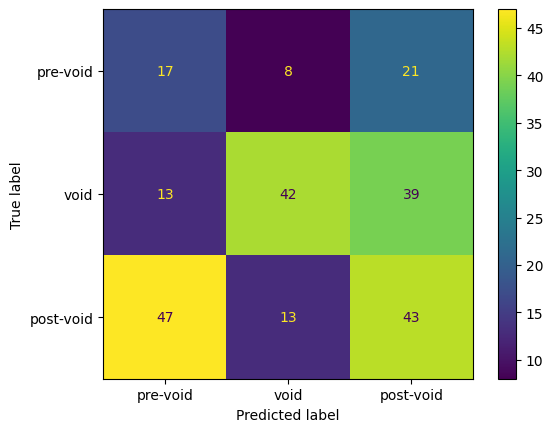

Classification Report:
              precision    recall  f1-score   support

    pre-void       0.22      0.37      0.28        46
        void       0.67      0.45      0.54        94
   post-void       0.42      0.42      0.42       103

    accuracy                           0.42       243
   macro avg       0.43      0.41      0.41       243
weighted avg       0.48      0.42      0.44       243



1

In [65]:
generate_accuracy_and_heatmap(model, X_test_selected, y_test)

In [66]:
rfe = RFE(estimator=model, step=1)
rfe = rfe.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
# Ensure full display
pd.set_option("display.max_rows", None)   # Show all rows
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.width", None)    # No wrapping
pd.set_option("display.max_colwidth", None)  # Show long column values

selected_rfe_features = pd.DataFrame({'Feature':list(X_train.columns),
                                    'Ranking':rfe.ranking_})
selected_rfe_features.sort_values(by='Ranking')

,Feature,Ranking
1,acc_x_spectral_entropy,1
2,acc_x_mean,1
5,acc_x_rms,1
4,acc_x_range,1
7,acc_x_min,1
13,acc_x_peak_frequency_ratio,1
11,acc_x_spectral_spread,1
8,acc_x_max,1
14,acc_x_hjorth_frequency,1
15,acc_x_spectral_skewness,1


In [ ]:
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

In [ ]:
X_train_rfe[0:3]

array([[ 7.27585759e-01,  8.40159411e-01,  5.25261990e+00,
         1.07943444e+00, -1.10746837e+00,  4.14515153e+00,
         2.93050307e+00,  5.40521081e-02,  6.31184522e-02,
         7.89463567e+00,  1.54050171e+00,  8.65194366e+00,
         8.73659515e-01,  3.27404313e-01,  8.85636510e-01,
        -2.88871095e+00,  3.10485309e+00,  3.29074145e+00,
         1.09165754e-01,  8.22348220e-02,  9.54522170e+00,
         9.72874961e-01,  7.82564817e+00,  8.46072133e-01,
         7.21074028e-01,  8.84124657e-01, -1.17222843e+00,
         2.05463065e+00,  3.40737713e+00,  9.12943870e+00,
         9.14944036e-01,  7.64464750e-01,  1.49193591e+00,
         1.65263642e+00,  1.35428654e-01,  4.34977566e+00,
         4.04789954e+00,  1.63802499e-01,  1.91441760e+00,
         8.07938344e+00,  8.85693546e-01,  7.00645747e-01,
         9.75335518e-01,  9.82960025e-01,  8.85806548e+00,
         5.48632143e+00,  8.07592777e-01,  6.44837393e-01,
        -7.75863408e-02,  1.32503773e+00, -5.32125656e+0

In [ ]:
model_rfe = model.fit(X_train_rfe, y_train)

Accuracy is:  0.6831275720164609
F1 Score is:  0.42962962962962964


Actual      0   1
Predicted        
0          14  20
1           4   5




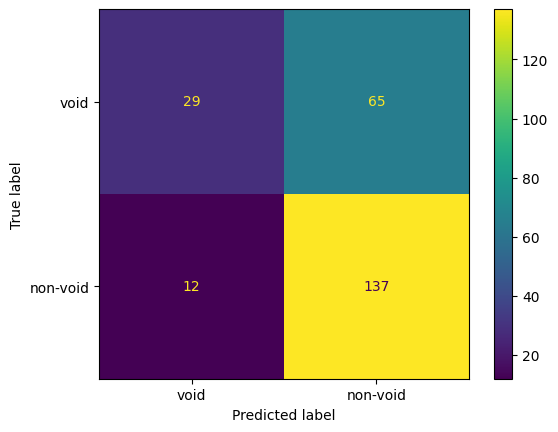

Classification Report:
              precision    recall  f1-score   support

        void       0.71      0.31      0.43        94
    non-void       0.68      0.92      0.78       149

    accuracy                           0.68       243
   macro avg       0.69      0.61      0.61       243
weighted avg       0.69      0.68      0.64       243



1

In [ ]:
generate_accuracy_and_heatmap(model_rfe, X_test_rfe, y_test)

In [ ]:
# rfecv = RFECV(estimator=model, step=1, cv=5, scoring='accuracy')
# rfecv = rfecv.fit(X_train, y_train)
# print('Optimal number of features :', rfecv.n_features_)
# print('Best features :', X_train.columns[rfecv.support_])

In [ ]:
# # Correct attributes:
# print("Optimal number of features:", rfecv.n_features_)
# # print("Cross-validation scores:", rfecv.cv_results_['mean_test_score'])
# # print("Selected features:", rfecv.support_)
# # print("Feature rankings:", rfecv.ranking_)

In [ ]:
# # This gives you the mean CV score for each number of features tested
# cv_scores = rfecv.cv_results_['mean_test_score']
# # print("CV scores:", cv_scores)

# # Plot the scores
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o')
# plt.xlabel('Number of Features')
# plt.ylabel('Cross-Validation Score')
# plt.title('RFECV Performance vs Number of Features')
# plt.grid(True)
# plt.show()

In [ ]:
# X_train_rfecv = rfecv.transform(X_train)
# X_test_rfecv = rfecv.transform(X_test)

In [ ]:
# model_rfecv = model.fit(X_train_rfecv, y_train)

In [ ]:
# generate_accuracy_and_heatmap(model_rfecv, X_test_rfecv, y_test)

In [ ]:
# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score of number of selected features")
# plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
# plt.show()